# Ailsa Craig

Ailsa Craig is a small island in the outer Firth of Clyde, 16 kilometres west of mainland Scotland. <br>
Important for our analysis that Ailsa Craig has a cliff on the south-west side.
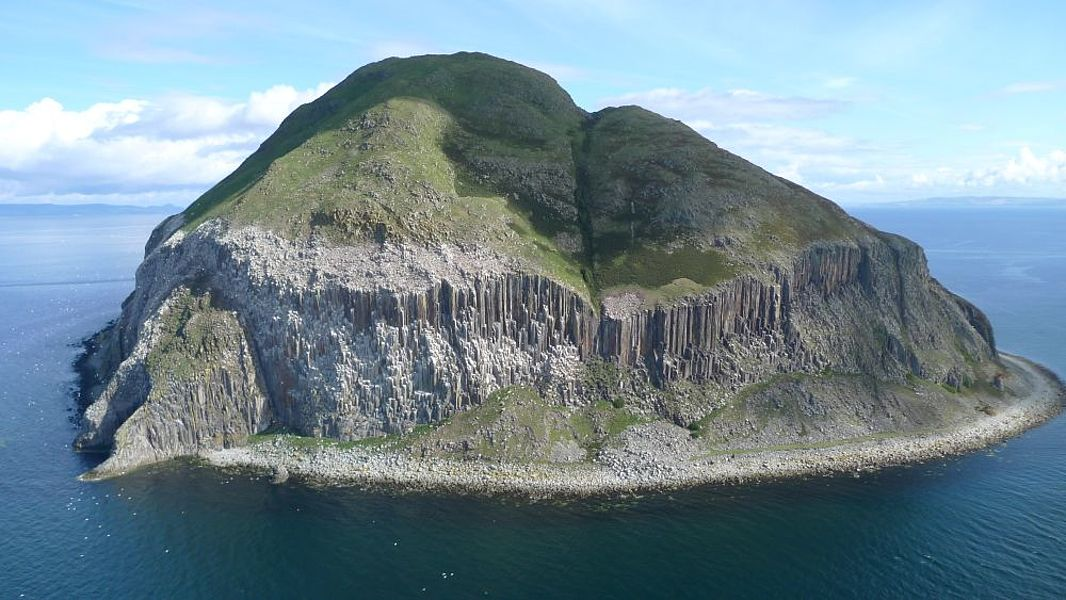

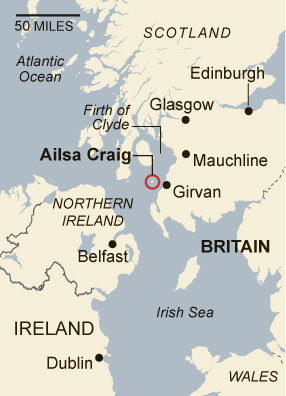

### Topography Ailsa Craig

In [15]:
# Install colour maps
%pip install cmocean

# Import all the necessary libraries
import numpy as np

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import folium
import cmocean as cmo
from scipy.fftpack import fft2,fftshift,ifft2,ifftshift
from scipy.special import kv
import warnings
warnings.filterwarnings('ignore')
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["figure.figsize"] = (10,10)

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Reading in the data
elevation_A = np.loadtxt('AilsaCraig.txt')

Text(0, 0.5, 'Distance from origin in northerly direction [m]')

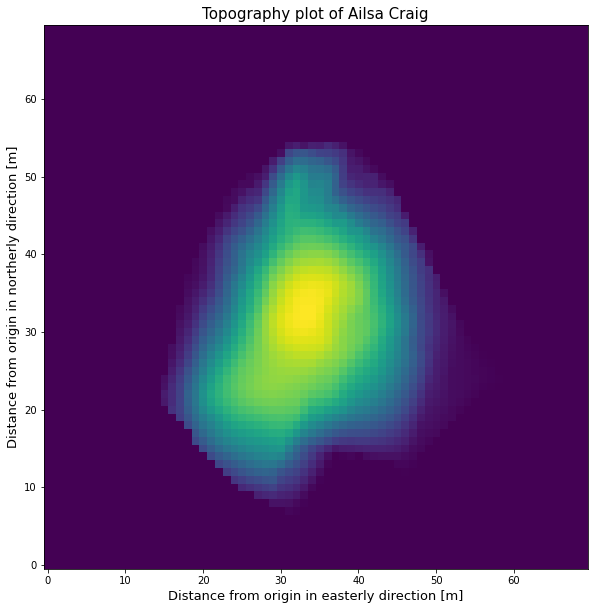

In [3]:
# Topography plot
fig, ax = plt.subplots()
plt.imshow(elevation_A[95:165, 95:165], origin='lower')
plt.title("Topography plot of Ailsa Craig", fontsize = 15)
plt.xlabel("Distance from origin in easterly direction [m]", fontsize = 13)
plt.ylabel("Distance from origin in northerly direction [m]", fontsize = 13)

# the island is surrounded by the sea
# is quite a pixelated plot

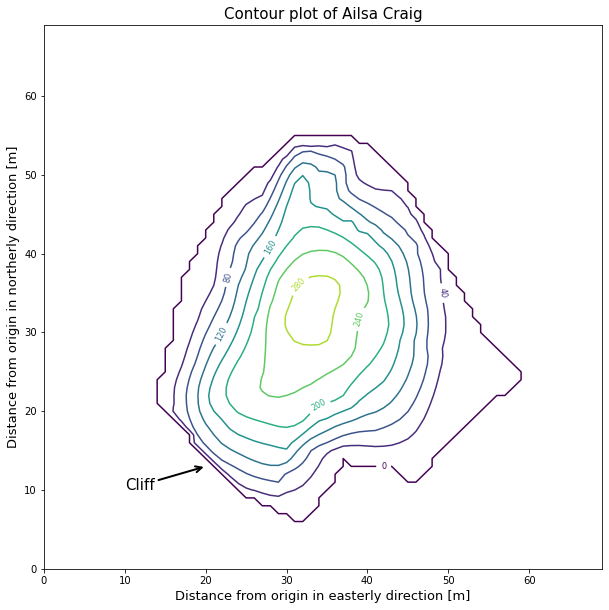

In [4]:
# Contour plot of North Berwick and Berwick Law
fig, ax = plt.subplots()

CS = ax.contour(elevation_A[95:165, 95:165])

ax.clabel(CS, inline=1, fontsize=8, fmt='%1.f')
ax.set_title('Contour plot of Ailsa Craig', fontsize = 15)
ax.set_xlabel("Distance from origin in easterly direction [m]", fontsize = 13)
ax.set_ylabel("Distance from origin in northerly direction [m]", fontsize = 13)

# Annotate the cliff location
ax.annotate('Cliff', xy=(20, 13),
             xycoords='data',
             xytext=(10, 10),
             fontsize = 15,
             textcoords='data',
             arrowprops=dict(arrowstyle= '->', color='black', lw=2))

plt.show()

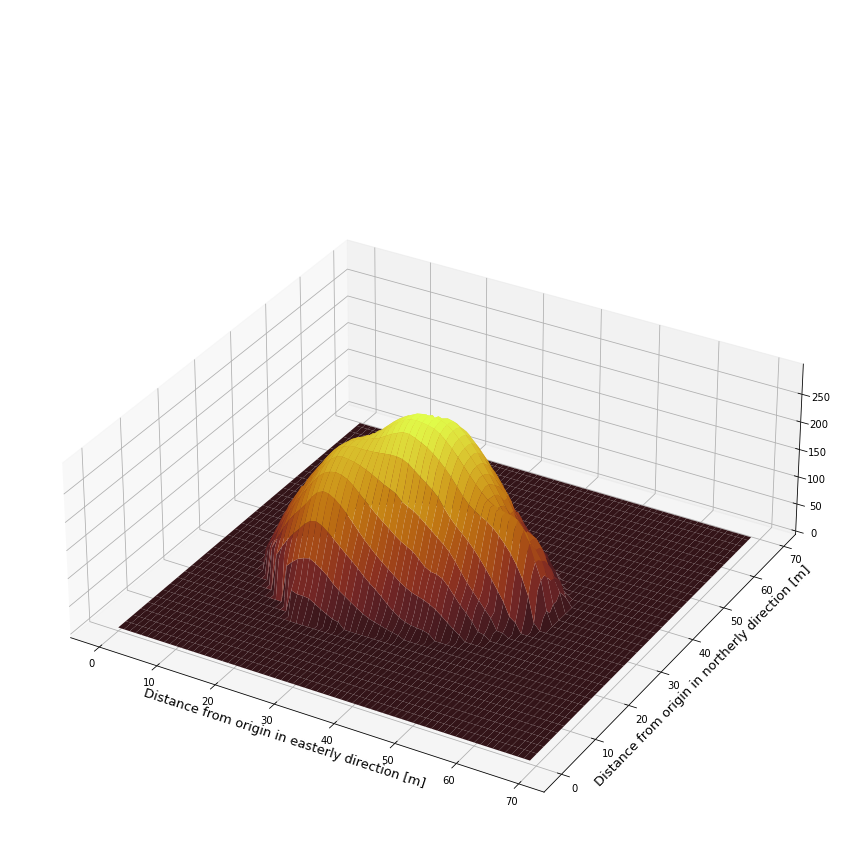

In [5]:
# Another way of using plot_surface

# Import data
fig = plt.figure(figsize=(20, 12))
ax = fig.gca(projection='3d')


# Scaling of the z-axis to make the plot less spiky and more realistic
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 1, 0.5, 1]))

# Define meshgrid and make data
elevation_sub = elevation_A[95:165, 95:165]
n=len(elevation_sub)
X = np.arange(0, n, 1)
Y = np.arange(0, n, 1)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
B = elevation_sub[X,Y]

# Plot the surface
ax.plot_surface(X, Y, B, cmap= cmo.cm.solar, rcount=50, ccount=100)
#ax.plot_surface(X, Y, B,rcount=50, ccount=100) # without color map
# deep, topo, balance, amp, turbid, solar
# I prefer solar or balance or deep

# Set axes labels
ax.set_xlabel("Distance from origin in easterly direction [m]", fontsize = 13)
ax.set_ylabel("Distance from origin in northerly direction [m]", fontsize = 13)

fig.tight_layout()

In [6]:
## Field work suggestions
# Need to add more locations, measurement 1 is an example

# Create the basemap
loc = [55.25, -5.11] # Coordinates of Edinburgh
m1 = folium.Map(location=loc, # Map centred at Ailsa Craig
                tiles='OpenStreetMap', 
                zoom_start=17) # Zoomed in to show central Edinburgh

# Add pop-up showing the coordinates when clicking anywhere on the map
m1.add_child(folium.LatLngPopup())

# Add a marker at Argyle House (Noteable's offices)
#tooltip = 'Click me!'
#locationName = 'Measurement 1' # Text for pop-up
#workloc = [ 56.0480, -2.7166] # Coordinates of Measurement 1
#folium.Marker(workloc, popup=locationName).add_to(m1) # Add the marker to basemap
display(m1)

# do we want to give suggestions for fieldworkd?

## Wind Ailsa Craig

In [7]:
## Calculate wind
# Parameters
topo_file_A = 'AilsaCraig.txt'       # Topography file name
dx = 25                     # Grid spacing (m)
L  = 500.                   # Horizontal length scale (m)
z0 = 0.01                    # Surface roughness length (m)
zu = 2.                      # Wind measurement height (m)

# Simulation with 1 m s$^{-1}$ wind from the west:
"""
Linear model for turbulent flow over low hills derived
from Jackson and Hunt (1975), Mason and Sykes (1979)
"""

# Iteration to find the inner region thickness l (m)
l = (z0/8)*(L/z0)**0.9
for i in range(10):
    l = 2*0.16*L/np.log(l/z0)
a = (np.log(L/z0))**2/(np.log(l/z0)*np.log(zu/z0))

# Read the topography file, find size and take a Fourier transform
z = np.loadtxt(topo_file_A)
n = z.shape[0]
Fz = fft2(z)
Fz = fftshift(Fz)

# Wavenumbers and modified Bessel functions
k = (2*np.pi/(n*dx))*np.arange(-n/2,n/2)       
m = (2*np.pi/(n*dx))*np.arange(-n/2,n/2)
bu = 1 - kv(0,2*np.sqrt(1j*L*k*zu/l))/kv(0,2*np.sqrt(1j*L*k*z0/l))
bv = 1 - kv(0,2*np.sqrt(2*1j*L*k*zu/l))/kv(0,2*np.sqrt(2*1j*L*k*z0/l))
bu[int(n/2)] = 0
bv[int(n/2)] = 0

# Fourier components of u and v
Fu = np.zeros_like(Fz)
Fv = np.zeros_like(Fz)
for i in range(n):
    for j in range(n):
        r = np.sqrt(k[j]**2 + m[i]**2)
        if r != 0:
            Fu[i,j] = a*bu[j]*(k[j]**2/r)*Fz[i,j]
            Fv[i,j] = a*bv[j]*(k[j]*m[i]/r)*Fz[i,j]

# Inverse Fourier transform
Fu = ifftshift(Fu)
Fv = ifftshift(Fv)
u = 1 + np.real(ifft2(Fu))
v = np.real(ifft2(Fv))
wind = np.sqrt(u**2 + v**2)

# Vertical wind component from continuity equation
w = np.zeros_like(wind)
dzdx = (z[1:-1,2:] - z[1:-1,:-2])/(2*dx)
dzdy = (z[2:,1:-1] - z[:-2,1:-1])/(2*dx)
w[1:-1,1:-1] = u[1:-1,1:-1]*dzdx + v[1:-1,1:-1]*dzdy

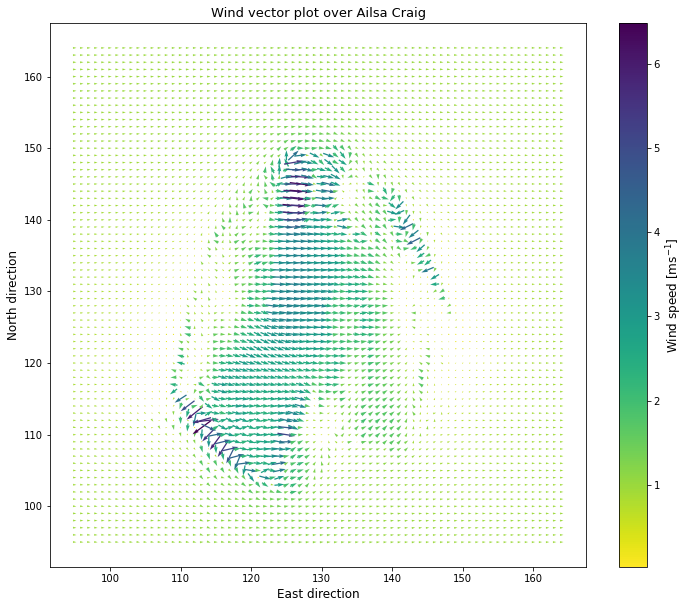

In [8]:
# Wind vector plot over hill

X = np.arange(0, 256)
Y = np.arange(0, 256)

fig, ax = plt.subplots(figsize=(12, 10))
#create quiver plot of data

q = ax.quiver(X[95:165], Y[95:165], u[95:165, 95:165], v[95:165, 95:165], wind[95:165, 95:165], cmap='viridis_r', pivot='mid', units='inches')

# set colourbar for the plot
cbar = fig.colorbar(q)
cbar.ax.set_ylabel('Wind speed [ms$^{-1}$]', fontsize = 12)

ax.set_title("Wind vector plot over Ailsa Craig", fontsize = 13)
ax.set_xlabel("East direction", fontsize=12)
ax.set_ylabel("North direction", fontsize=12)
plt.show()

# if we use the plots from different hills next to each other
# we should couple the color bars as it is confusing otherwise

# zoom in 

(array([100. , 102.5, 105. , 107.5, 110. , 112.5, 115. , 117.5, 120. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

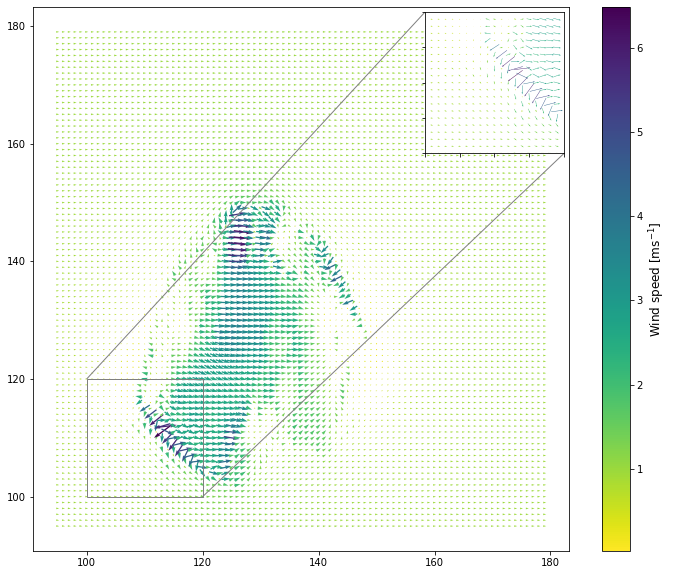

In [31]:
X = np.arange(0, 256)
Y = np.arange(0, 256)

fig, ax = plt.subplots(figsize=(12, 10))
#create quiver plot of data

q = ax.quiver(X[95:180], Y[95:180], u[95:180, 95:180], v[95:180, 95:180], wind[95:180, 95:180], cmap='viridis_r', pivot='mid', units='inches')

# set colourbar for the plot
cbar = fig.colorbar(q)
cbar.ax.set_ylabel('Wind speed [ms$^{-1}$]', fontsize = 12)

extent = (100, 120, 100, 120)

# Define position of the zoomed-in plot
axins = zoomed_inset_axes(ax, 1.2, loc=1)
axins.quiver(X[100:120], Y[100:120], u[100:120, 100:120], v[100:120, 100:120], wind[100:120, 100:120], cmap='viridis_r', pivot='mid', units='inches')
axins.set_xlim(100, 120)
axins.set_ylim(100, 120)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

# Set to false, so that x and yticks are not shown
plt.xticks(visible=False)
plt.yticks(visible=False)

## does not look good 

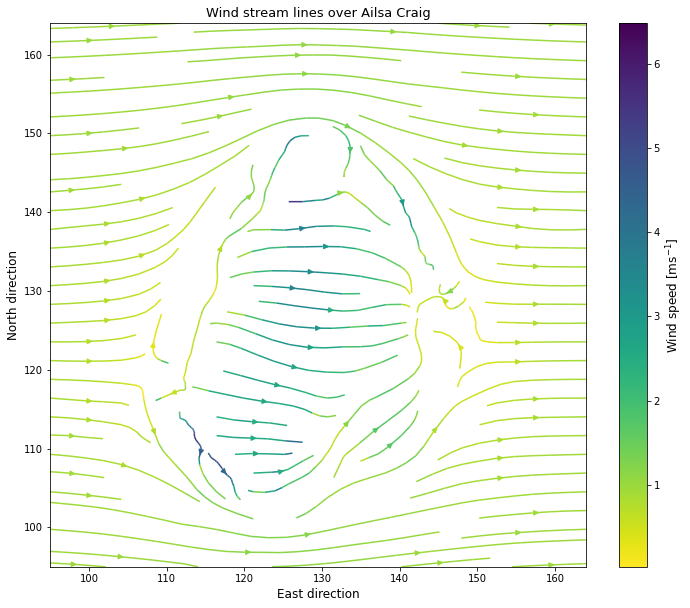

In [9]:
# Wind stream lines over hill

#create stream plot

fig, ax = plt.subplots(figsize=(12, 10))
strm = ax.streamplot(X[95:165], Y[95:165], u[95:165, 95:165], v[95:165, 95:165], color=wind[95:165, 95:165], cmap='viridis_r')

#set colourbar according to wind speed
cbar = fig.colorbar(strm.lines)
cbar.ax.set_ylabel('Wind speed [ms$^{-1}$]', fontsize = 12)

ax.set_title("Wind stream lines over Ailsa Craig", fontsize = 13)
ax.set_xlabel("East direction", fontsize = 12)
ax.set_ylabel("North direction", fontsize = 12)

plt.show()

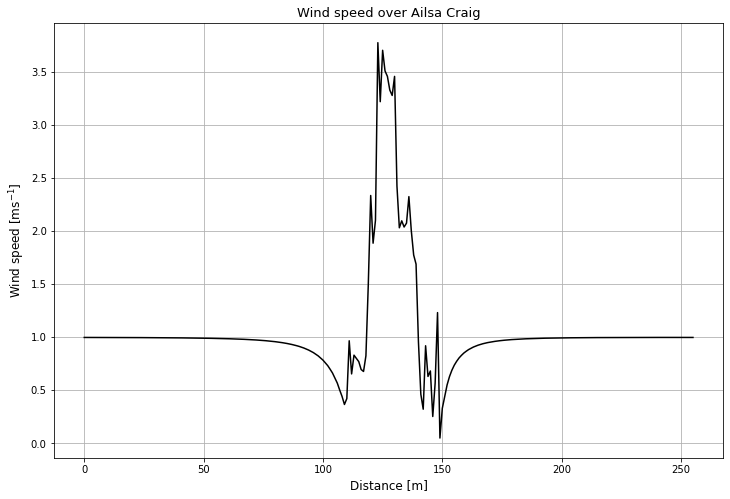

In [10]:
# Wind speed over top of hill
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(wind[128,:], c = "k")
ax.set_title("Wind speed over Ailsa Craig", fontsize = 13)
ax.set_xlabel("Distance [m]", fontsize = 12)
ax.set_ylabel("Wind speed [ms$^{-1}$]", fontsize = 12)
ax.grid()

## Plotting vertical component of wind

Text(0.5, 1.0, 'Vertical wind component over summit of Ailsa Craig')

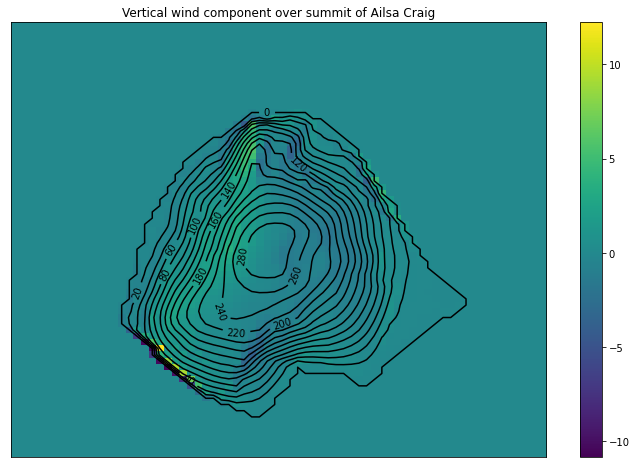

In [38]:
# Plot vertical wind component and topography for 1 km x 1 km area centred on the summit
fig, ax = plt.subplots(figsize=(12,8))

plt.imshow(w[95:165, 95:165],origin='lower', aspect='auto')  # north at the top of the image
plt.colorbar()
cs = plt.contour(z[95:165, 95:165],colors='k',levels=np.arange(0,1000,20))
plt.clabel(cs,fmt='%d')
plt.xticks([])
plt.yticks([])
plt.title("Vertical wind component over summit of Ailsa Craig")

## 3D wind speed plot

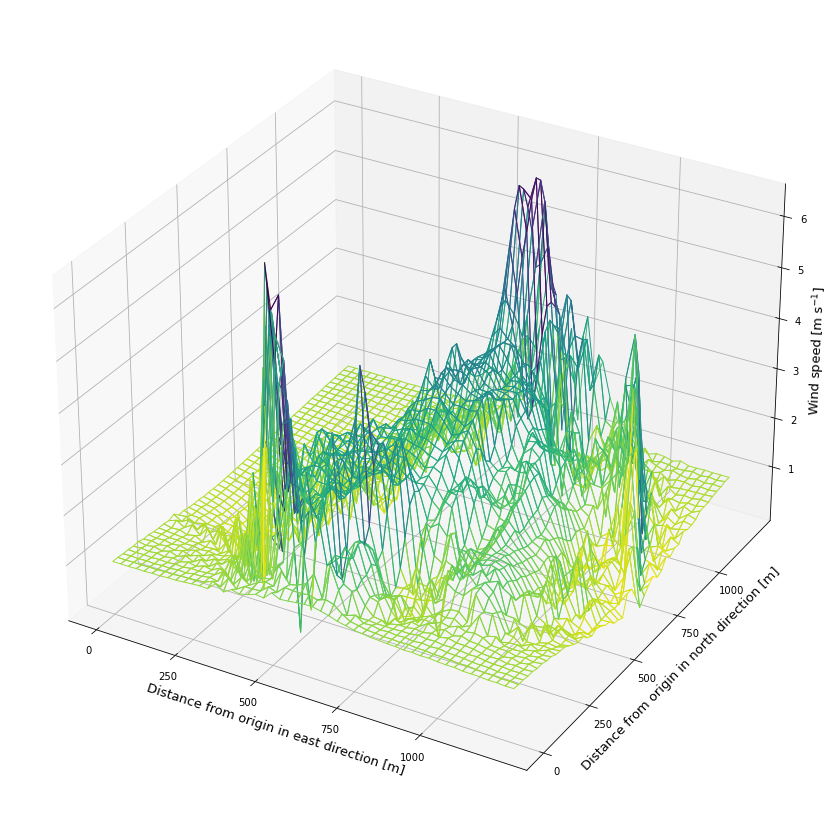

In [12]:
# Wind speed 3d plot around the hill

from mpl_toolkits.mplot3d import axes3d
import matplotlib.cm as cm

#%matplotlib notebook
def surface_plot(data):
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')
    x = np.arange(0, 50)
    y = np.arange(0, 50)
    X, Y = np.meshgrid(x, y)

    # Normalize to [0,1]
    Z = data[100:150, 100:150]
    norm = plt.Normalize(Z.min(), Z.max())
    colors = cm.viridis_r(norm(Z))
    rcount, ccount, _ = colors.shape
    

    surf = ax.plot_surface(X, Y, Z, rcount=rcount, ccount=ccount,
                           facecolors=colors, shade=False)
    surf.set_facecolor((0,0,0,0))
    


    ax.set_xlabel('Distance from origin in east direction [m]', fontsize=13)
    ax.set_ylabel('Distance from origin in north direction [m]', fontsize=13)
    ax.set_zlabel('Wind speed [m s$^{-1}$]', fontsize=13)
    plt.xticks(np.arange(0, 50, step=10), labels=[0,250,500,750,1000])
    plt.yticks(np.arange(0, 50, step=10), labels=[0,250,500,750,1000])
    #ax.set_title("3D plot of wind speed around North Berwick Law", fontsize=14)
    #ax.view_init(30, 110) # change the viewing angle
    
surface_plot(wind)

# I would not include this plot as it is too messy

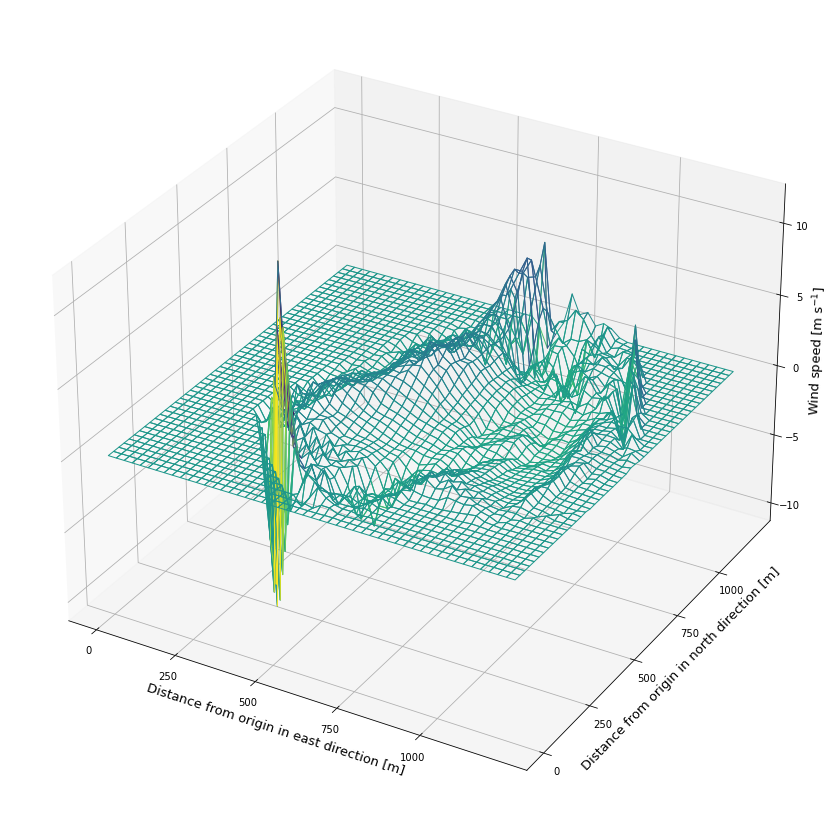

In [13]:
# 3D plot of Vertical wind speed component (w)

surface_plot(w)

## interesting as there is a cliff in the lowrt right corner
# we can analyse the limitations of the model (ie does not work for cliffs)